In [1]:
#PARSES GENBANK FILES AND ANALYZES CODON CONTEXTS BOTH DURING INITIATION AND ELONGATION
#the fist code block gets the sequences out of the Genbank file and makes a lists of genes and of the sequences

genomeFileName = '/content/gdrive/Shared drives/2.Python/Genomics/Data Files/E.coli.K12.sequence.2.gb'
codonTableName = '/content/gdrive/Shared drives/2.Python/Genomics/Data Files/E.coli.K12.CodonTable.txt'
initiationContexts = '/content/gdrive/Shared drives/2.Python/Genomics/Data Files/E.coli.K12.InitiationContexts.txt'

import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from google.colab import drive
drive.mount('/content/gdrive')
with open(genomeFileName, 'r') as f:
  data = f.read()
f.close()
txtfile = str(data)
start = 3
stop  = 3
frame = 0

#Breaks out the features and the sequence
split1 = txtfile.split('FEATURES') #list[0] is annotations, [1] is the good stuff
split2 = split1[1].split('ORIGIN')  #divides gene locations [0] and genome sequence [1]
features = split2[0].split('  gene  ')  #separates each gene location and puts them in a list
seq = ''
for char in split2[1]:                  #puts sequence in a single, long string
    if char in ('t', 'g', 'c', 'a'):
        seq += char
        
print('The number of "Features" lines =', len(features))
print('The first Features line starts with:', features[1][:100])
print('The first 100 nucleotides =', seq[:100])        
split1[0] = '' #deletes from memory the annotations in the beginning of the gb file  
split2[0] = '' #deletes from memory the unsplit features list  

#COLLECT ALL THE FORWARD AND REVERSE GENES and labels them as 'FOR' or 'REV'
names =[]
forward =0
reverse =0

for x in range(1, len(features)):
  if 'join' not in features[x]:
    if 'complement' not in features[x]:genedirection = 'FOR'
    elif 'complement' in features[x]:  genedirection = 'REV'
    cleanfeatures = features[x].replace('complement(','').replace(')', '')\
    .replace('/', '').replace(' ', '').replace('gene="', '').replace('"', '')
    workgene = cleanfeatures.split('\n')
    genename = workgene[1]
    genelocation = workgene[0].split('.')
    genestart = genelocation[0] 
    geneend = genelocation[2] 
    genedata = [genedirection, genename, genestart, geneend, 0, 0.0]
    names.append(genedata)
              
#converts gene starts and ends to integers.  Calulates gene length
print('The number of annotated genes =', len(names))
for y in range(len(names)):
  try:
    names[y][2] = int(names[y][2])
    names[y][3] = int(names[y][3])
    names[y][4] = int(names[y][3]) - int(names[y][2])
  except: print('Bad gene:', names[y])
                  
genes =[]
for x in range(len(names)):
  if names[x][0] == 'FOR':
    cds = seq[names[x][2] -1 : names[x][3]]
  elif names[x][0] == 'REV':
    transposed = ''
    flipped = seq[names[x][2] -1 : names[x][3]]
    for char in flipped:
      if char == 'a': newchar = 't'
      elif char == 't': newchar = 'a'
      elif char == 'c': newchar = 'g'
      elif char == 'g': newchar = 'c'
      transposed += newchar
    cds = transposed[::-1]
  genes.append(cds)

#collects only those sequences that have proper start codons
startgenes =[]
startnames =[]
for x in range(len(genes)):
  if genes[x][0:3]  in ('atg', 'gtg', 'ctg', 'ttg', 'att', 'ata', 'aaa'):
    startgenes.append(genes[x])
    startnames.append(names[x])

#Collects only those sequences that do not contain internal stop codons
goodgenes =[]
goodnames =[]
badgenes = set()
for x in range(len(startgenes)):
  keep = True
  for a in range(start, len(startgenes[x]) - stop):
    if a % 3 == 0 :
      if startgenes[x][a:a+3] in ('tag', 'taa', 'tga'): 
        badgenes.add(startnames[x][1])
        keep = False
        continue
  if keep == True:
    goodgenes.append(startgenes[x])
    goodnames.append(startnames[x])  

print(badgenes)
print(len(badgenes))
print('The number of good genes =', len(goodnames))

codons = ['ttt','ttc','tta','ttg', 'ctt','ctc','cta','ctg', 'att','atc','ata','atg', 'gtt','gtc','gta','gtg',\
          'tct','tcc','tca','tcg', 'cct','ccc','cca','ccg', 'act','acc','aca','acg', 'gct','gcc','gca','gcg',\
          'tat','tac','taa','tag', 'cat','cac','caa','cag', 'aat','aac','aaa','aag', 'gat','gac','gaa','gag',\
          'tgt','tgc','tga','tgg', 'cgt','cgc','cga','cgg', 'agt','agc','aga','agg', 'ggt','ggc','gga','ggg']

counts =[]
for x in range(len(codons)):
  counts.append(0)

for x in range(len(goodgenes)):
    for a in range(start, len(goodgenes[x]) -stop): 
        if a % 3 == frame  :
            codon = goodgenes[x][a:a+3] 
            for b in range(len(codons)):
                if codons[b] == codon: counts[b] += 1  

#CALCULATE PERCENTAGES OF EACH CODON
totalcodons =0
frequency =[]
for x in range(len(codons)):
    totalcodons += counts[x]
totalcodons -= 2 * len(goodgenes) #subtracts 2 from each gene, one each for start and stop codons
print( 'Total codons =', totalcodons )

none = True
for x in range(len(goodgenes)):
  for a in range(6, len(goodgenes[x]) -6):
    if a % 3 == 0:
      if goodgenes[x][a:a+3] == 'tag' : none = False

print(none)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
The number of "Features" lines = 4567
The first Features line starts with:           190..255
                     /gene="thrL"
                     /locus_tag="b0001"
       
The first 100 nucleotides = agcttttcattctgactgcaacgggcaatatgtctctgtgtggattaaaaaaagagtgtctgatagcagcttctgaactggttacctgccgtgagtaaat
The number of annotated genes = 4546
{'ybeM', 'fdhF', 'yghX', 'yjhZ', 'gapC', 'yneL', 'ybcY', 'pbl', 'rrsA', 'ycgH', 'insZ', 'fdnG', 'yehH', 'yfcU', 'mdtQ', '

r for 2nd position = 0.9474704324915444 , slope = 0.11748064185091893 , intercept = -0.314817147121933 , p_val = 2.1516571125743507e-32
max2 = 444 max3 = 301
fraction of non-ATG genes = 0.10075260985676135


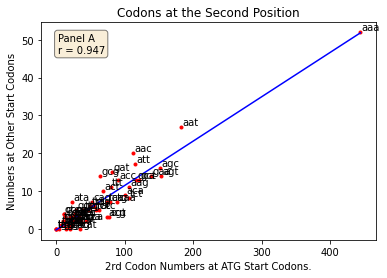

r for 3rd position = 0.9042225490804958 , slope = 0.1017760792812723 , intercept = 0.5940844115963655 , p_val = 1.3697046001008084e-24


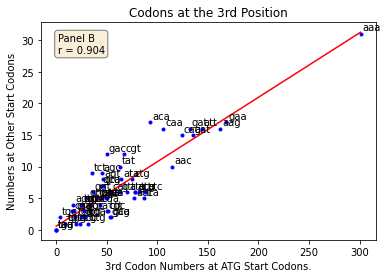

In [2]:
# this block counts and plots neighbors for ATG-starters vs those at other start codons
# it addresses two codons downstream

import math
codcon = []
for x in range(len(codons)):
  codcon.append([codons[x], 0, 0, 0, 0])

atggenes =0
btggenes =0
for x in range(len(goodgenes)):
  start  = goodgenes[x][0:3]  
  second = goodgenes[x][3:6]  
  third  = goodgenes[x][6:9]  
  if start == 'atg':
    atggenes +=1
    for b in range(len(codcon)):
      if second == codcon[b][0] : codcon[b][1] += 1
      if third  == codcon[b][0] : codcon[b][2] += 1
  else:
    btggenes +=1
    for b in range(len(codons)):
      if second == codcon[b][0] : codcon[b][3] += 1
      if third  == codcon[b][0] : codcon[b][4] += 1

atg2, atg3, btg2, btg3, cod = [], [], [], [], []
for x in range(len(codcon)):
  #print(codcon[x])
  cod.append(codcon[x][0])
  atg2.append(codcon[x][1])
  atg3.append(codcon[x][2])
  btg2.append(codcon[x][3])
  btg3.append(codcon[x][4])

slope2, intercept2, r_value2, p_value2, std_err = stats.linregress(atg2, btg2)
print ('r for 2nd position =', r_value2, ', slope =', slope2, ', intercept =', intercept2, ', p_val =', p_value2)
max2 = max(atg2)
max3 = max(atg3)
print('max2 =', max2, 'max3 =', max3)
print('fraction of non-ATG genes =', btggenes / (atggenes + btggenes))  

# plot second codon
fig, ax = plt.subplots()
textstr = 'Panel A\nr = ' +str(r_value2)[:5]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
for i,type in enumerate(cod):
    x =  atg2[i]
    y =  btg2[i]
    plt.scatter(x, y, marker='.', color='r')
    plt.text(x+ 2, y+ 0.5, cod[i], fontsize=10)
plt.title('Codons at the Second Position')
plt.xlabel('2rd Codon Numbers at ATG Start Codons.')
plt.ylabel('Numbers at Other Start Codons')
x4 = [0, max2]             #[0, the maximal x1 value]
y4 = [intercept2, slope2 * max2 + intercept2]     #[intercept, slope * the maximal x1 value + intercept]
plt.plot(x4, y4, 'b-')  #note: use 'plt.plot' not 'plt.scatter,

plt.show()

# plots for 3rd position
slope3, intercept3, r_value3, p_value3, std_err = stats.linregress(atg3, btg3)
fig, ax = plt.subplots()
textstr = 'Panel B\nr = ' +str(r_value3)[:5]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
plt.title('Codons at the 3rd Position')
plt.xlabel('3rd Codon Numbers at ATG Start Codons.')
plt.ylabel('Numbers at Other Start Codons')
print ('r for 3rd position =', r_value3, ', slope =', slope3, ', intercept =', intercept3, ', p_val =', p_value3)
x5 = [0, max3]
y5 = [intercept3, slope3 * max3 + intercept3]
plt.plot(x5, y5, 'r-')
for i,type in enumerate(cod):
    x =  atg3[i]
    y =  btg3[i]
    plt.scatter(x, y, marker='.', color='b')
    plt.text(x+ 2, y+ 0.5, cod[i], fontsize=10)


sums 4119 1246045
r for 2nd position = 0.37415716345830197 , slope = 0.002064770261574014 , intercept = 24.15942717839075 , max2 = 66801 , p_val = 0.0023212486737277213


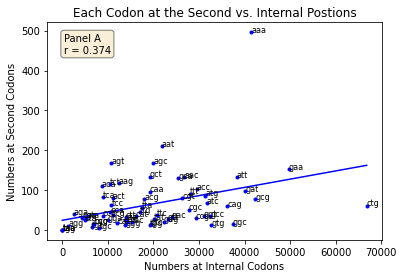

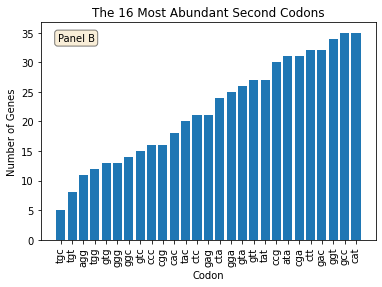

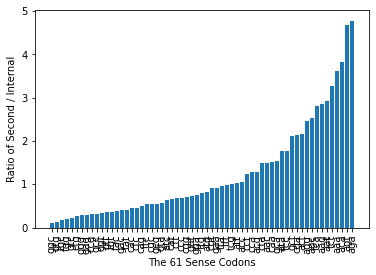

In [3]:
# CODON frequencies between the second codon and internal positions FOR ALL AMINO ACIDS
# ALL CODONS FOR SPECIFIC AMINO ACIDS ARE IN NEXT BLOCK

target = 'atg'

inel = []                            # fill array with lists of codons and 0 counts for init and elong
for x in range(len(codons)):
  inel.append([codons[x], 0, 0])

# THIS SECTION LOOKS AT ALL SECOND CODONS vs ALL INTERNAL CODONS
for x in range(len(goodgenes)):      # count codons at 2nd position
  for b in range(len(inel)):
    if inel[b][0] == goodgenes[x][3:6] : inel[b][1] +=1

for x in range(len(goodgenes)):
  for a in range(8, len(goodgenes[x]) -6):
    if a % 3 == 0:
      for b in range(len(inel)):
          if inel[b][0] == goodgenes[x][a:a+3] : inel[b][2] +=1
           
sumstart =0
sumelong =0
for x in range(len(inel)):
  sumstart += inel[x][1]
  sumelong += inel[x][2]
print('sums', sumstart, sumelong)

for x  in range(len(inel)):             
  if inel[x][2] >0:
    startfrq = inel[x][1] /sumstart
    elongfrq = inel[x][2] / sumelong
    inel[x].append( startfrq / elongfrq )      # inel[3]
  else: 
    inel[x].append(0)

inel.sort(key = lambda x: x[1])
#inel.reverse()


"""
for z in range(len(inel)):
  print (str(z+1) + 'th', inel[z])
"""
xval, yval, cod, barval = [], [], [], []
for x in range(len(inel)):
  xval.append(inel[x][2])
  yval.append(inel[x][1])
  barval.append(inel[x][1])
  cod.append(inel[x][0])

elongmax = max(xval)

slope2, intercept2, r_value2, p_value2, std_err = stats.linregress(xval, yval)
print ('r for 2nd position =', r_value2, ', slope =', slope2, ', intercept =', intercept2,\
       ', max2 =', elongmax, ', p_val =', p_value2)
fig, ax = plt.subplots()
textstr = 'Panel A\nr = ' +str(r_value2)[:5]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
x4 = [0, elongmax]             #[0, the maximal x1 value]
y4 = [intercept2, slope2 * elongmax + intercept2]     #[intercept, slope * the maximal x1 value + intercept]

plt.plot(x4, y4, 'b-')  #note: use 'plt.plot' not 'plt.scatter,
plt.title('Each Codon at the Second vs. Internal Postions')
plt.xlabel('Numbers at Internal Codons')
plt.ylabel('Numbers at Second Codons')

for i,type in enumerate(cod):
    x = xval[i]
    y = yval[i]
    plt.scatter(x, y, marker='.', color='b')
    plt.text(x+ 2, y+ 0.003, cod[i], fontsize=8)
plt.show()

fig, ax = plt.subplots()
textstr = 'Panel B'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
bars = cod[3:30] 
barvals = barval[3:30]
plt.title('The 16 Most Abundant Second Codons')
plt.ylabel('Number of Genes')
barcolor = plt.bar(bars, barvals)
#barcolor[2].set_color('b')
plt.xticks(rotation = 90)
plt.xlabel('Codon')
plt.show()

inel.sort(key = lambda x: x[3])
#inel.reverse()

xval, yval, cod, barval = [], [], [], []
for x in range(len(inel)):
  xval.append(inel[x][2])
  yval.append(inel[x][1])
  barval.append(inel[x][3])
  cod.append(inel[x][0])

bars = cod[3:64] 
barvals = barval[3:64]
plt.ylabel('Ratio of Second / Internal')
barcolor = plt.bar(bars, barvals)
#barcolor[0].set_color('b')
plt.xticks(rotation = 90)
plt.xlabel('The 61 Sense Codons')
plt.show()

sums 4119 1246045
['cgt', 80, 26302, 0.019422189851905802, 0.02117839549216298]
['cgg', 16, 6770, 0.0038844379703811605, 0.005451210458594151]
['cgc', 51, 27780, 0.012381646030589949, 0.02236848250217807]
['cga', 31, 4381, 0.007526098567613498, 0.0035275853794831578]
['agg', 11, 1350, 0.002670551104637048, 0.0010870212879028219]
['aga', 39, 2467, 0.009468317552804079, 0.0019864307535231566]
165.06647900391386


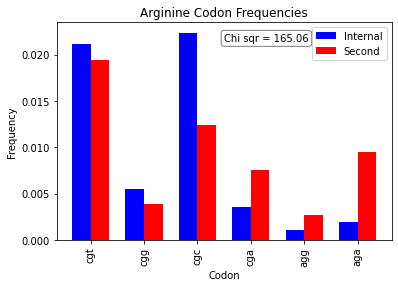

In [10]:
# CODON frequencies between the second codon and internal positions FOR SPECIFIC AMINO ACIDS  
# AMINO ACID contexts are in the next block
# YOU MUST """ OUT EITHER THE SECTION FOR ALL CODONS OR FOR ONLY THOSE FOLLOWING ATG

target = 'atg'
Isoleucine = ['gtt', 'gtg', 'gtc', 'gta']
Serine  = ['tct', 'tcc', 'tca', 'tcg', 'agt', 'agc']  
Lysine = ['aaa', 'aag']
Leucine = ['tta', 'ttg', 'ctt', 'ctc', 'cta', 'ctg']
Valine = ['gtt', 'gtc', 'gta', 'gtg']
Glycine = ['ggt', 'ggc', 'gga', 'ggg']
Glutamine = ['caa', 'cag']
Phenylalanine = [ 'ttt', 'ttc']
Arginine = ['cgt', 'cgc', 'cga', 'cgg', 'aga', 'agg']
Others = ['tgt', 'tgc', 'tat', 'tac', 'cat', 'cac', 'act', 'acc', 'aca', 'acg']
aalist = Arginine
aaname = 'Arginine'

inel = []                            # fill array with lists of codons and 0 counts for init and elong
for x in range(len(codons)):
  inel.append([codons[x], 0, 0, 0])

# THIS SECTION LOOKS AT ALL SECOND CODONS vs ALL INTERNAL CODONS
for x in range(len(goodgenes)):      # count codons at 2nd position
  for b in range(len(inel)):
    if inel[b][0] == goodgenes[x][3:6] : inel[b][1] +=1

for x in range(len(goodgenes)):
  for a in range(9, len(goodgenes[x]) -6):
    if a % 3 == 0:
      for b in range(len(inel)):
          if inel[b][0] == goodgenes[x][a:a+3] : inel[b][2] +=1
           
sumstart =0
sumelong =0
for x in range(len(inel)):
  sumstart += inel[x][1]
  sumelong += inel[x][2]
print('sums', sumstart, sumelong)

for x  in range(len(inel)):             
  if inel[x][0] in aalist and inel[x][2] >0:
    startfrq = inel[x][1] / sumstart
    elongfrq = inel[x][2] / sumelong
    inel[x].append( startfrq / elongfrq )     
  else: 
    inel[x].append(0)

inel.sort(key = lambda x: x[3])
inel.reverse()

# Amino acids
pltaalist = []
for x in range(len(inel)):
  if inel[x][0] in aalist:
    pltaalist.append( [ inel[x][0], inel[x][1], inel[x][2] ])

sumstart = 4119
sumelong = totalcodons - 2*len(goodnames)
for x in range(len(pltaalist)):
  pltaalist[x].append(pltaalist[x][1] / sumstart)
  pltaalist[x].append(pltaalist[x][2] / sumelong)

#pltaalist.sort(key = lambda x: x[3])
pltaalist.sort()
pltaalist.reverse()

[print(x) for x in pltaalist]

# calculate Chi square
sumsnd =0
sumint =0
for x in range(len(pltaalist)):
  sumsnd += pltaalist[x][3]
  sumint += pltaalist[x][4]

scaled =  sumint / sumsnd
chisum = 0.0
for x in range(len(pltaalist)):
  chisum += (pltaalist[x][1]  - len(goodnames)  * pltaalist[x][4])**2  / (len(goodnames) * pltaalist[x][4])
print(chisum)

#plotting
barnames, barvals1, barvals2 = [], [], []
for x in range(len(pltaalist)):
  barnames.append(pltaalist[x][0])
  barvals1.append(pltaalist[x][4])
  barvals2.append(pltaalist[x][3])
 
# create plot
fig, ax = plt.subplots()
index = np.arange(len(barnames))
bar_width = 0.35
opacity = 1

plt.bar(index, barvals1, bar_width,
alpha=opacity,
color='b',
label='Internal')

plt.bar(index + bar_width, barvals2, bar_width,
alpha=opacity,
color='r',
label='Second')

textstr = 'Chi sqr = ' + str(chisum)[:6] 
props = dict(boxstyle='round', facecolor='white',alpha=0.5)  # 
ax.text(0.5, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', horizontalalignment= 'left', bbox=props)

plt.xlabel('Codon')
plt.ylabel('Frequency')
plt.title(aaname+ ' Codon Frequencies')
plt.xticks(index + bar_width /2, barnames, rotation = 90)
plt.legend()

plt.show()


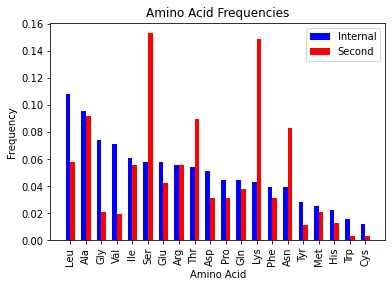

In [5]:
# AMINO ACID context at ATG in both initiation and internal positions.  
# CODON contexts are in the last block
# YOU MUST """ OUT EITHER THE 'ALL CODONS' OR 'ONLY THOSE AFTER ATG' SECTIONS

target = 'atg'
inel = []                            # fill array with lists of codons and 0 counts for init and elong
for x in range(len(codons)):
  inel.append([codons[x], 0, 0, 0])

# THIS SECTION LOOKS AT ALL SECOND CODONS vs ALL INTERNAL CODONS
for x in range(len(goodgenes)):      # count codons at 2nd position
  for a in range(len(inel)):
    if goodgenes[x][3:6] == inel[a][0]: inel[a][1] +=1
    if goodgenes[x][6:9] == inel[a][0]: inel[a][2] +=1

for x in range(len(goodgenes)):
  for a in range(9, len(goodgenes[x]) -6):
    if a %3 == 0:
      for b in range(len(inel)):
        if inel[b][0] == goodgenes[x][a:a+3] : inel[b][3] +=1

aas =  [ [('ttt', 'ttc'), 'Phe', 0, 0, 0], [('tta','ttg', 'ctt', 'ctc', 'cta', 'ctg'), 'Leu', 0, 0, 0] , 
      [('att', 'atc', 'ata'), 'Ile', 0,0, 0], [('atg'), 'Met', 0, 0, 0], [('gtt', 'gtc', 'gta', 'gtg'), 'Val', 0, 0, 0],
      [('tct', 'tcc', 'tca', 'tcg', 'agt', 'agc'), 'Ser', 0, 0, 0], [('cct', 'ccc', 'cca', 'ccg'), 'Pro', 0, 0, 0],\
      [('act', 'acc', 'aca', 'acg'), 'Thr', 0, 0, 0], [('gct', 'gcc', 'gca', 'gcg'), 'Ala', 0, 0, 0],\
      [('tat', 'tac'), 'Tyr', 0, 0, 0], [('cat', 'cac'), 'His', 0, 0, 0], [('caa', 'cag'), 'Gln', 0, 0, 0],\
      [('aat', 'aac'), 'Asn', 0, 0, 0], [('gat', 'gac'), 'Asp', 0, 0, 0], [('gaa', 'gag'), 'Glu', 0, 0, 0],\
      [('tgt', 'tgc'), 'Cys', 0, 0, 0], [('tgg'), 'Trp', 0, 0, 0],\
      [('cgt', 'cgc', 'cga', 'cgg', 'aga', 'agg'),'Arg', 0, 0, 0], [('ggt', 'ggc', 'gga', 'ggg'), 'Gly', 0, 0, 0],\
      [('aaa', 'aag'), 'Lys', 0, 0, 0]  ]

for x in range(len(inel)):
  for y in range(len(aas)):
    if inel[x][0] in aas[y][0] : 
      aas[y][2] += inel[x][1]
      aas[y][3] += inel[x][2]
      aas[y][4] += inel[x][3]

sumfirst =0
sumsecond =0
sumelong =0
for x in range(len(aas)):
  sumfirst += aas[x][2]
  sumsecond += aas[x][3]
  sumelong += aas[x][4]

for x  in range(len(aas)):
  firstfrq = aas[x][2] / sumfirst
  secondfrq = aas[x][3] /sumsecond
  elongfrq = aas[x][4] / sumelong
  aas[x].append( firstfrq )
  aas[x].append( secondfrq )
  aas[x].append( elongfrq )
# aas = set, name, fst, snd, eln, frqfst, frqsnd, frqeln
#       0     1     2    3    4     5        6      7
aas.sort(key = lambda x: x[4])
aas.reverse()
#for z in range(len(aas)):
 # print (str(z+1) + 'th', aas[z])

barnames, barvals1, barvals2, barvals3 = [], [], [], []
for x in range(len(aas)):
  barnames.append(aas[x][1])
  barvals1.append(aas[x][7])
  barvals2.append(aas[x][5])
  barvals3.append(aas[x][6])

# create plot
fig, ax = plt.subplots()
index = np.arange(len(aas))
bar_width = 0.3
opacity = 1

plt.bar(index, barvals1, bar_width,
alpha=opacity,
color='b',
label='Internal')

plt.bar(index + bar_width, barvals2, bar_width,
alpha=opacity,
color='r',
label='Second')
"""
plt.bar(index + 2* bar_width, barvals3, bar_width,
alpha=opacity,
color='g',
label='Third')
"""
plt.xlabel('Amino Acid')
plt.ylabel('Frequency')
plt.title('Amino Acid Frequencies')
plt.xticks(index + bar_width /2, barnames, rotation = 90)
plt.legend()

#plt.tight_layout()
plt.show()

[[2025, 597, 846, 651], [1512, 764, 674, 1169], [1343, 1303, 676, 797], [1724, 579, 941, 875], [1730, 1033, 550, 806], [1260, 1192, 871, 796], [311049, 193920, 436864, 304212], [357691, 378906, 225940, 283506], [222126, 326043, 360567, 337305]]
4119 1225450
14
14
14
14


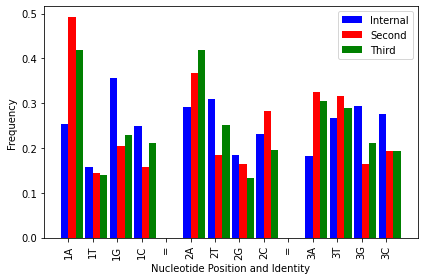

In [6]:
# BLOCK FOR NUCLEOTIDE FREQS AT FIRST AND SECOND CODONS COMPARED TO AT ALL INTERNAL CODONS
from matplotlib import pyplot as plt

nts = [ [0,0,0,0], [0,0,0,0], [0,0,0,0],    # nt numbers for the second codon
        [0,0,0,0], [0,0,0,0], [0,0,0,0],    # nt numbers for the third codon
        [0,0,0,0], [0,0,0,0], [0,0,0,0] ]   # nt numbers for internal codon positions

for x in range(len(goodgenes)):
  if goodgenes[x][3] == 'a': nts[0][0] += 1
  if goodgenes[x][3] == 't': nts[0][1] += 1
  if goodgenes[x][3] == 'g': nts[0][2] += 1
  if goodgenes[x][3] == 'c': nts[0][3] += 1

  if goodgenes[x][4] == 'a': nts[1][0] += 1
  if goodgenes[x][4] == 't': nts[1][1] += 1
  if goodgenes[x][4] == 'g': nts[1][2] += 1
  if goodgenes[x][4] == 'c': nts[1][3] += 1

  if goodgenes[x][5] == 'a': nts[2][0] += 1
  if goodgenes[x][5] == 't': nts[2][1] += 1
  if goodgenes[x][5] == 'g': nts[2][2] += 1
  if goodgenes[x][5] == 'c': nts[2][3] += 1

  if goodgenes[x][6] == 'a': nts[3][0] += 1
  if goodgenes[x][6] == 't': nts[3][1] += 1
  if goodgenes[x][6] == 'g': nts[3][2] += 1
  if goodgenes[x][6] == 'c': nts[3][3] += 1

  if goodgenes[x][7] == 'a': nts[4][0] += 1
  if goodgenes[x][7] == 't': nts[4][1] += 1
  if goodgenes[x][7] == 'g': nts[4][2] += 1
  if goodgenes[x][7] == 'c': nts[4][3] += 1

  if goodgenes[x][8] == 'a': nts[5][0] += 1
  if goodgenes[x][8] == 't': nts[5][1] += 1
  if goodgenes[x][8] == 'g': nts[5][2] += 1
  if goodgenes[x][8] == 'c': nts[5][3] += 1

for x in range(len(goodgenes)):
  for a in range(9, len(goodgenes[x]) -6):
    if a % 3 == 0:
      if goodgenes[x][a] == 'a': nts[6][0] += 1
      if goodgenes[x][a] == 't': nts[6][1] += 1
      if goodgenes[x][a] == 'g': nts[6][2] += 1
      if goodgenes[x][a] == 'c': nts[6][3] += 1
    elif a % 3 ==1:
      if goodgenes[x][a] == 'a': nts[7][0] += 1
      if goodgenes[x][a] == 't': nts[7][1] += 1
      if goodgenes[x][a] == 'g': nts[7][2] += 1
      if goodgenes[x][a] == 'c': nts[7][3] += 1
    elif a % 3 ==2:
      if goodgenes[x][a] == 'a': nts[8][0] += 1
      if goodgenes[x][a] == 't': nts[8][1] += 1
      if goodgenes[x][a] == 'g': nts[8][2] += 1
      if goodgenes[x][a] == 'c': nts[8][3] += 1

print(nts)

startdenominator = len(goodgenes) 
interdenominator = totalcodons - (6 * len(goodgenes) )
print (startdenominator, interdenominator)

barnames = ['1A', '1T', '1G', '1C', '=', '2A', '2T', '2G', '2C', '=', '3A', '3T', '3G', '3C']
barvals1, barvals2, barvals3 = [], [], []

for x in range(0,3):
  for y in range(4):
    barvals1.append(nts[x][y] / startdenominator)
    if x < 2 and y == 3:
      barvals1.append(0)

for x in range(3,6):
  for y in range(4):
    barvals2.append(nts[x][y] / startdenominator)
    if x < 5 and y ==3:
      barvals2.append(0)

for x in range(6,9):
  for y in range(4):
    barvals3.append(nts[x][y] / interdenominator)  
    if x < 8 and y == 3:
      barvals3.append(0)

print(len(barvals1))
print(len(barvals2))
print(len(barvals3))
print(len(barnames))

# create plot
#fig, ax = plt.subplots()
index = np.arange(len(barnames))
bar_width = 0.3
opacity = 1

plt.bar(index, barvals3, bar_width,
alpha=opacity,
color='b', 
label='Internal')

plt.bar(index + bar_width, barvals1, bar_width,
alpha=opacity,
color='r',
label='Second')

plt.bar(index + 2*bar_width, barvals2, bar_width,
alpha=opacity,
color='g',
label='Third')

plt.xlabel('Nucleotide Position and Identity')
plt.ylabel('Frequency')
#plt.title('Nucleotide Frequencies')
plt.xticks(index + bar_width /2, barnames, rotation = 90)
plt.legend()

plt.tight_layout()
plt.show()


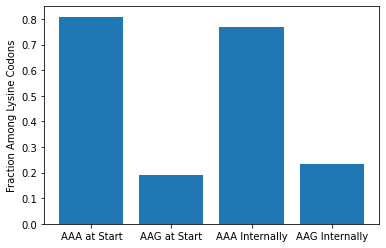

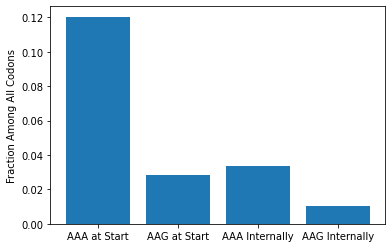

In [7]:
# block for comparing AAA and AAG usage at initation and internally

# usage[0][0] = aaa at start, usage[0][1] = aag at start, usage[1][0] = internal aaa; usage[1][1] = internal aag
bars = ['AAA at Start', 'AAG at Start', 'AAA Internally', 'AAG Internally']
usage = [0,0,0,0]

total_internal=0
for x in range(len(goodgenes)):
  if goodgenes[x][3:6] == 'aaa' : usage[0] +=1
  if goodgenes[x][3:6] == 'aag' : usage[1] +=1
  for a in range(6, len(goodgenes[x]) -6):
    if a % 3 == 0:
      total_internal +=1
      if goodgenes[x][a:a+3] == 'aaa' : usage[2] +=1
      if goodgenes[x][a:a+3] == 'aag' : usage[3] +=1

plot = [usage[0] / (usage[0] + usage[1]), usage[1] / (usage[0] + usage[1]),\
        usage[2] / (usage[2] + usage[3]), usage[3] / (usage[2] + usage[3]) ]
plt.ylabel('Fraction Among Lysine Codons')

plt.bar(bars, plot)
plt.show()

plot = [usage[0] / len(goodgenes), usage[1] / len(goodgenes),\
        usage[2] / total_internal, usage[3] / total_internal ]
plt.ylabel('Fraction Among All Codons')

plt.bar(bars, plot)
plt.show()
